In [31]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Model, load_model
from keras.utils import to_categorical # one-hot-encoding

# Required for loss function
import math

from unet_utilz import *

In [2]:
IMG_HEIGHT = 81
IMG_WIDTH = 81
LABEL_CLASS = 3

seed = 42
random.seed = seed
np.random.seed = seed

In [26]:
# Importing data...


# Path for Windows
PATH = 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\'


# Get train and test IDs
img_ids = next(os.walk(PATH + 'test\\in\\'))[2]
mask_ids = next(os.walk(PATH + 'test\\out\\'))[2]
DIM_ids = next(os.walk(PATH + 'DIM_test\\'))[2]
RES_ids = next(os.walk(PATH + 'res_test\\'))[2]


# X_test: original images
X_test = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
# Y_test: masks
Y_test = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

# Decision Image from DISCO
DIM = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
# Original result from DISCO
RES = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)
    
    
# Get and resize test images
print('Getting and resizing images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    
    img = imread(PATH + 'test\\in\\' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH)
    
    
print('Getting and resizing masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    
    mask = imread(PATH + 'test\\out\\' + id_)
    mask = label_to_mask(mask)
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
    
    
print('Getting and resizing DIMs ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(DIM_ids), total=len(DIM_ids)):
    
    img = imread(PATH + 'DIM_test\\' + id_)
    DIM[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH)    
    

print('Getting and resizing results ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(RES_ids), total=len(RES_ids)):
    
    mask = imread(PATH + 'res_test\\' + id_)
    mask = label_to_mask_DISCO(mask)
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    #mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    RES[n] = mask
    
print('Done!')

Getting and resizing images ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 559.50it/s]


Getting and resizing masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:10<00:00, 17.28it/s]


Getting and resizing DIMs ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 610.73it/s]


Getting and resizing results ... 


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:04<00:00, 39.41it/s]


Done!


In [27]:
DIM.shape

(173, 81, 81, 1)

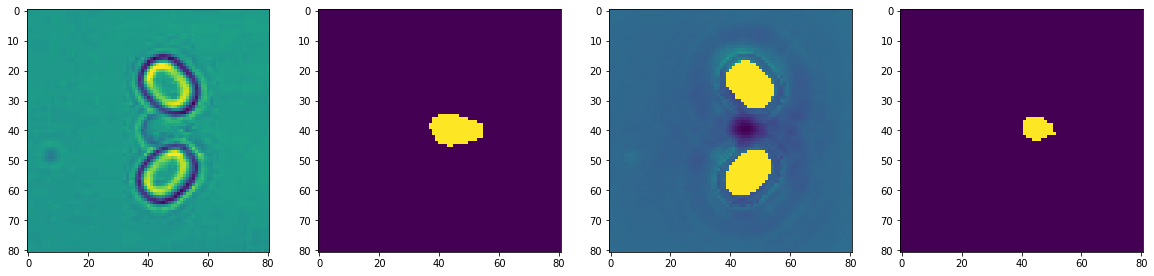

In [4]:
ix = random.randint(0, len(img_ids)-1)

plt.figure(figsize=(20,20))
plt.subplot(141), plt.imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.subplot(142), plt.imshow(Y_test[ix,:,:,2]) #, plt.axis('off')
plt.subplot(143), plt.imshow(np.reshape(DIM[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.subplot(144), plt.imshow(RES[ix,:,:,2]) #, plt.axis('off')
plt.show()

In [6]:
from sklearn.metrics import roc_curve, auc # roc curve tools

ground_truth_labels_cell = Y_test[:,:,:,2].ravel() # we want to make them into vectors
ground_truth_labels_trap = Y_test[:,:,:,1].ravel()
score_value_trap = DIM.ravel()/255.0 
score_value_cell = 1 - score_value_trap

fpr_cell, tpr_cell, _ = roc_curve(ground_truth_labels_cell,score_value_cell)
auc_cell = auc(fpr_cell,tpr_cell)

fpr_trap, tpr_trap, _ = roc_curve(ground_truth_labels_trap,score_value_trap)
auc_trap = auc(fpr_trap,tpr_trap)

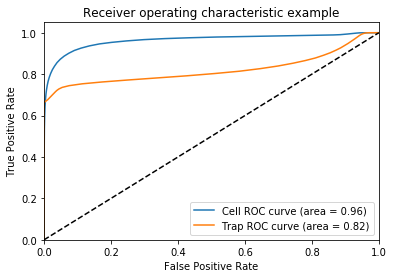

In [12]:
fig, ax = plt.subplots(1,1)
ax.figsize=(20,10)
ax.plot(fpr_cell, tpr_cell, label='Cell ROC curve (area = %0.2f)' % auc_cell)
ax.plot(fpr_trap, tpr_trap, label='Trap ROC curve (area = %0.2f)' % auc_trap)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

In [7]:
# Compute average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ground_truth_labels_cell,score_value_cell)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.85


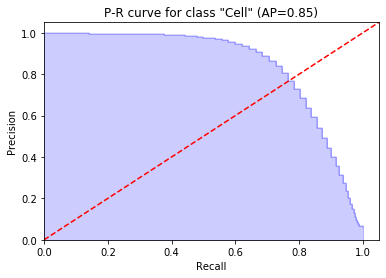

In [8]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision_cell, recall_cell, thresh_cell = precision_recall_curve(ground_truth_labels_cell,score_value_cell)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_cell, precision_cell, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_cell, precision_cell, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('P-R curve for class "Cell" (AP={0:0.2f})'.format(
          average_precision))

plt.plot([0.0, 1.05],[0.0, 1.05],color='r', ls='--')

plt.show()
#plt.savefig('PR-Curve.png')

In [9]:
for i in range(len(precision_cell)):
    if precision_cell[i] > recall_cell[i]:
        print(i)
        break

93


In [10]:
print(thresh_cell[92])
print(precision_cell[92])
print(recall_cell[92])

0.60784316
0.7680240226756097
0.7848293662173789
